In [1]:
import subprocess
import os
import sys

import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../')
from utils import *

# path with scPerturb data (replace accordingly)
data_path = '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'
# temp path
SDIR = '/fast/scratch/users/peidlis_c/perturbation_resource_paper/'
# output from snakemake (tables)
table_path = '/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/'
# path for figures
figure_path = '../figures/'
# path for supplemental figures and tables
supp_path = '../supplement/'

In [3]:
# get indecs of dataset
h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name: h5_files[name.split('.h5')[0]] = os.path.join(path, name)
del h5_files['exampledataset']
del h5_files['NormanWeissman2019_raw']
del h5_files['PapalexiSatija2021_eccite_arrayed_protein']
del h5_files['PapalexiSatija2021_eccite_protein']
del h5_files['FrangiehIzar2021_protein']
del h5_files['gene_scores']
del h5_files['peak_bc']
del h5_files['ChromVar']
del h5_files['LSI_embedding']
del h5_files['markerpeak_target']

# del h5_files['XieHon2017']
datasets = list(h5_files.keys())
# print(len(datasets))

In [4]:
# set colors
colors_perturbation_types = {
    'CRISPRi': 'tab:blue', 
    'CRISPRa': 'tab:red', 
    'CRISPR': 'tab:orange',
    'CRISPR-cas9': 'tab:orange',
    'drugs': 'tab:green',
    'cytokine': 'tab:olive'
}

In [36]:
estats_datasets = {}
estats_control_datasets = {}
for key in h5_files.keys():
    if not os.path.exists(f'{table_path}/pairwise_pca_distances_{key}_tables.csv'):
        continue
    # load pca and bulk pca pairwise distances
    pwd = pd.read_csv(f'{table_path}/pairwise_pca_distances_{key}_tables.csv', index_col=0)
    if 'control' not in pwd.index or len(pwd.index)<3:
        continue
    
    # derive basic statistics
    sigmas = np.diag(pwd)
    deltas = pwd
    
    estats = 2 * deltas - sigmas - sigmas[:, np.newaxis]
    estats = cluster_matrix(estats, 'both')
    estats_control = estats.loc[:, 'control']
    
    key = 'McFarlandTsherniak2020' if 'McFarland' in key else key  # typo
    
    estats_control_datasets[key] = estats_control
    estats_datasets[key] = estats

In [37]:
# aggregate
df = pd.concat(estats_control_datasets).reset_index()
df.columns = ['dataset', 'perturbation', 'E-distance']
# prettier names
df['dataset_pretty'] = [x.replace('TAP_SCREEN__', '') for x in df.dataset]
df['dataset_pretty'] = [x.replace('_', '\n(', 1)+')' if '_' in x else x for x in df.dataset_pretty]
df['dataset_pretty'] = [x.replace('_', ' ') for x in df.dataset_pretty]

In [38]:
# This is the excel table on the datasets
metadata = pd.read_excel('../metadata/scperturb_dataset_info_180822.xlsx', index_col=0)
metadata['dataset_id'] = [i if pd.isna(x) else f'{i}_{x}' for i, x in zip(metadata.index, metadata.dataset_index)]
metadata = metadata.set_index('dataset_id')
metadata.head()

,dataset_index,Title,doi/url,First Author,Organisms,Modality = Data type,Method,Tissues,Number of perturbations (incl. unperturbed),Perturbation,disease,celltype,tissue type,Cancer,multiple time points?,multiple concentrations?,combined perturbations?,Date of Submission,Year,Mini-Abstract (loosely summarized original Abstract)
dataset_id,,,,,,,,,,,,,,,,,,,,
AdamsonWeissman2016_GSM2406675_10X001,GSM2406675_10X001,A multiplexed single-cell CRISPR screening pla...,https://doi.org/10.1016/j.cell.2016.11.048,Britt Adamson,Homo sapiens,RNA,Perturb-seq,K562,10,CRISPR-cas9,chronic myelogenous leukemia,lymphoblasts,cell_line,y,n,n,y,2019-10-01,2019,Perturb-seq is applied to dissect the mammalia...
AdamsonWeissman2016_GSM2406677_10X005,GSM2406677_10X005,A multiplexed single-cell CRISPR screening pla...,https://doi.org/10.1016/j.cell.2016.11.048,Britt Adamson,Homo sapiens,RNA,Perturb-seq,K562,21,CRISPR-cas9,chronic myelogenous leukemia,lymphoblasts,cell_line,y,n,n,y,2019-10-01,2019,Perturb-seq is applied to dissect the mammalia...
AdamsonWeissman2016_GSM2406681_10X010,GSM2406681_10X010,A multiplexed single-cell CRISPR screening pla...,https://doi.org/10.1016/j.cell.2016.11.048,Britt Adamson,Homo sapiens,RNA,Perturb-seq,K562,115,CRISPR-cas9,chronic myelogenous leukemia,lymphoblasts,cell_line,y,n,n,y,2019-10-01,2019,Perturb-seq is applied to dissect the mammalia...
AissaBenevolenskaya2021,NaN,Single-cell transcriptional changes associated...,https://doi.org/10.1038/s41467-021-21884-z,Alexandre Aissa,Homo sapiens; Mus musculus,RNA,Drop-Seq,"cell lines, patient tissue, mouse xenografts",4,drugs,NaN,NaN,cell_line,y,partially,n,partially,2020-11-01,2020,This study uses scRNA-seq to demonstrate the e...
ChangYe2021,NaN,Identifying transcriptional programs underlyin...,https://doi.org/10.1038/s41587-021-01005-3,Matthew Chang,Homo sapiens,RNA,clonal tagging (TraCe-seq),"lung and breast cancer cell lines PC9, MCF-10A...",4,drugs,lung adenocarcinoma,NaN,NaN,y,n,n,n,2021-08-01,2021,By conducting clonal fitness mapping and scRNA...


In [40]:
# add more detailed perturbation_type annotation
df['perturbation_type_'] = None
for dataset in pd.unique(df.dataset):
    val = metadata.loc[dataset, 'Perturbation'].replace(', TCR stim', '')
    df.loc[df.dataset==dataset, 'perturbation_type_'] = val

# Fig4B

In [74]:
order = df.value_counts(['dataset_pretty', 'perturbation_type_'], sort=False).reset_index().sort_values('perturbation_type_', ascending=False).dataset_pretty

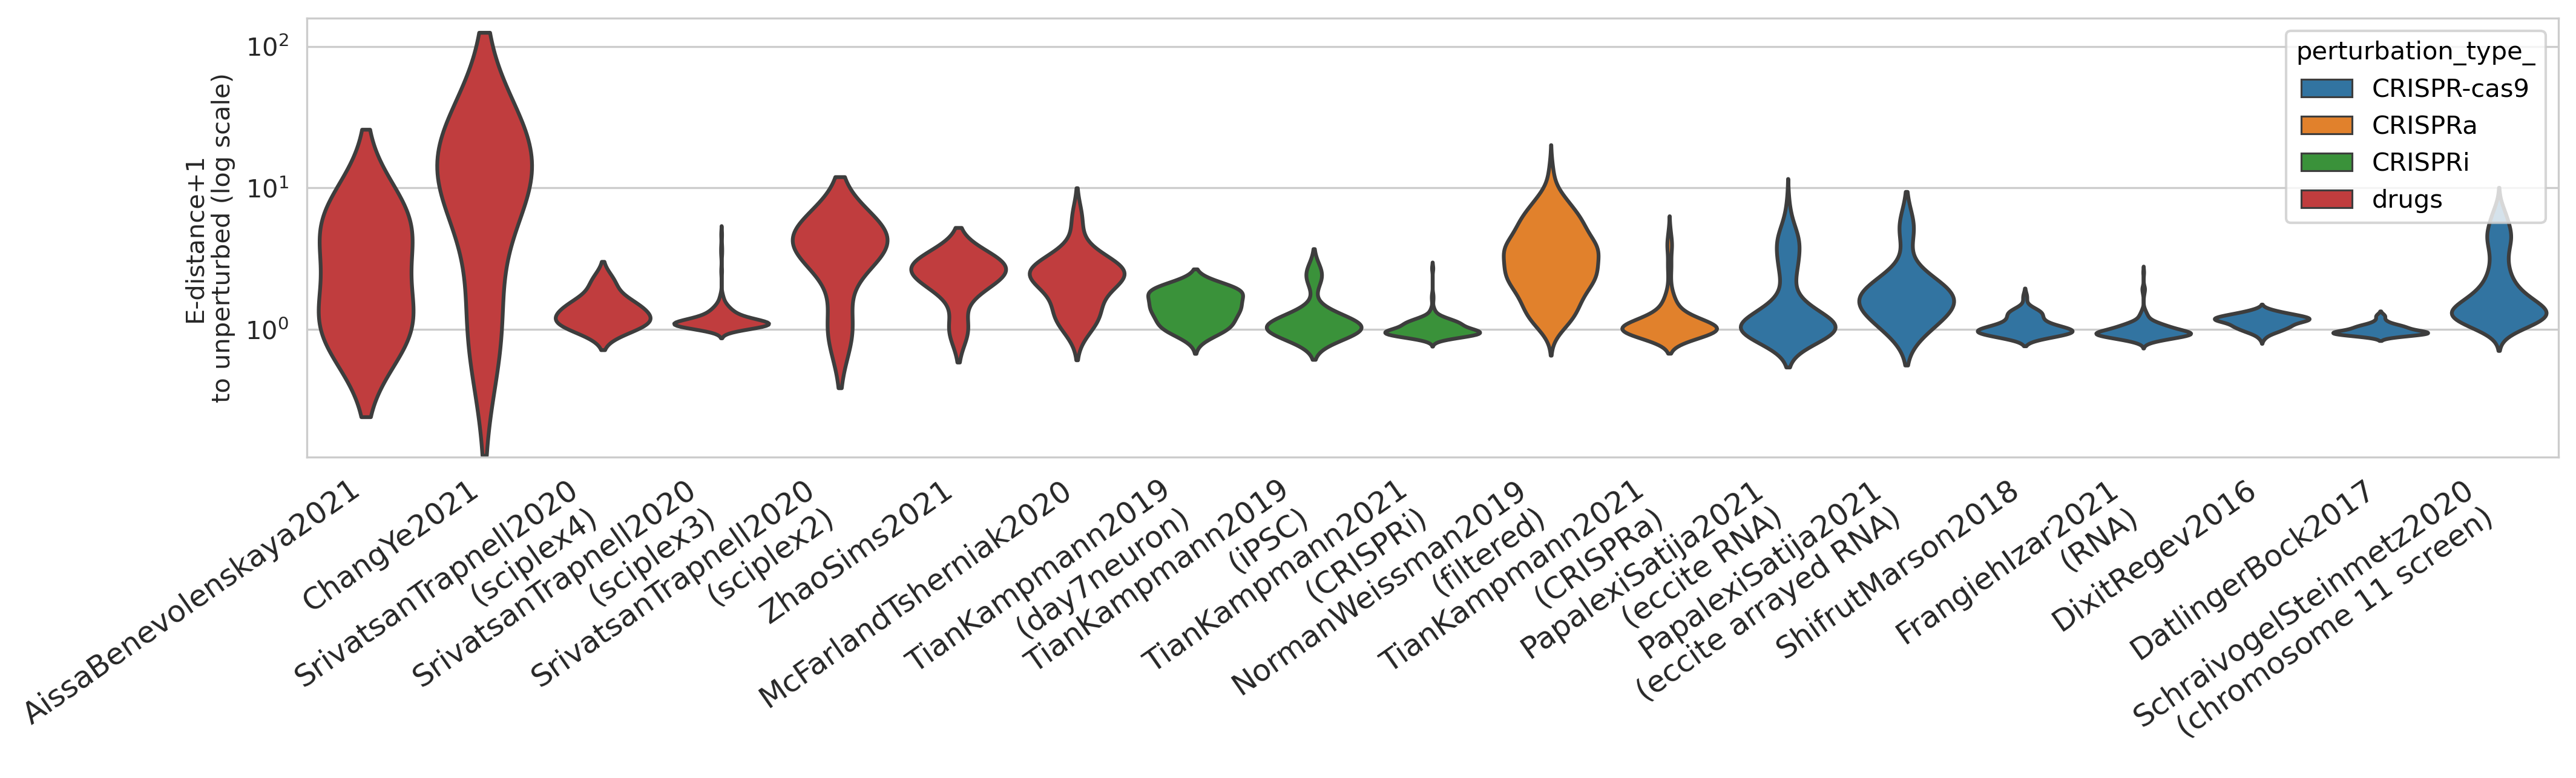

In [76]:
scale = 0.8
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[20*scale, 4*scale], dpi=300)
df['tmp'] = np.log10(df['E-distance']+1)
vp = sns.violinplot(data=df, x='dataset_pretty', y='tmp', inner=None, dodge=False, hue='perturbation_type_', order=order)
pl.xticks(rotation=35, ha='right', fontsize=12)
pl.ylabel('E-distance+1\nto unperturbed (log scale)')
pl.xlabel('')
# pl.xlabel('Datasets')

# log scale y ticks
from matplotlib import ticker as mticker
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ymin, ymax = ax.get_ylim()
tick_range = np.arange(0, 3)
ax.yaxis.set_ticks(tick_range)
ax.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
ax.set_ylim([-0.9, 2.2])

pl.savefig(f'{figure_path}/Fig4B.pdf', bbox_inches='tight')
pl.show()

# Fig4C

In [77]:
key = 'NormanWeissman2019_filtered'
pairs = pairs_datasets[key]
estats = estats_datasets[key]
estats_control = pd.DataFrame(estats.loc[:, 'control'])
estats_control.columns=['E-statistic']

In [78]:
indices = list(estats_control['E-statistic'].sort_values().index)
N = 3
top=indices[-N:]
bot=indices[:N]
strong = list(estats_control.index[estats_control['E-statistic']>2]) + ['control']

In [79]:
# add e-test results
tab = pd.read_csv(f'{table_path}etest_{key}_tables.csv', index_col=0)
if 'pvalue' not in estats_control.columns:
    estats_control = pd.merge(estats_control, tab, left_index=True, right_index=True, how='left')
estats_control['significant_adj_'] =  estats_control['significant_adj']
estats_control.loc['control', 'significant_adj_'] = 'Unperturbed'

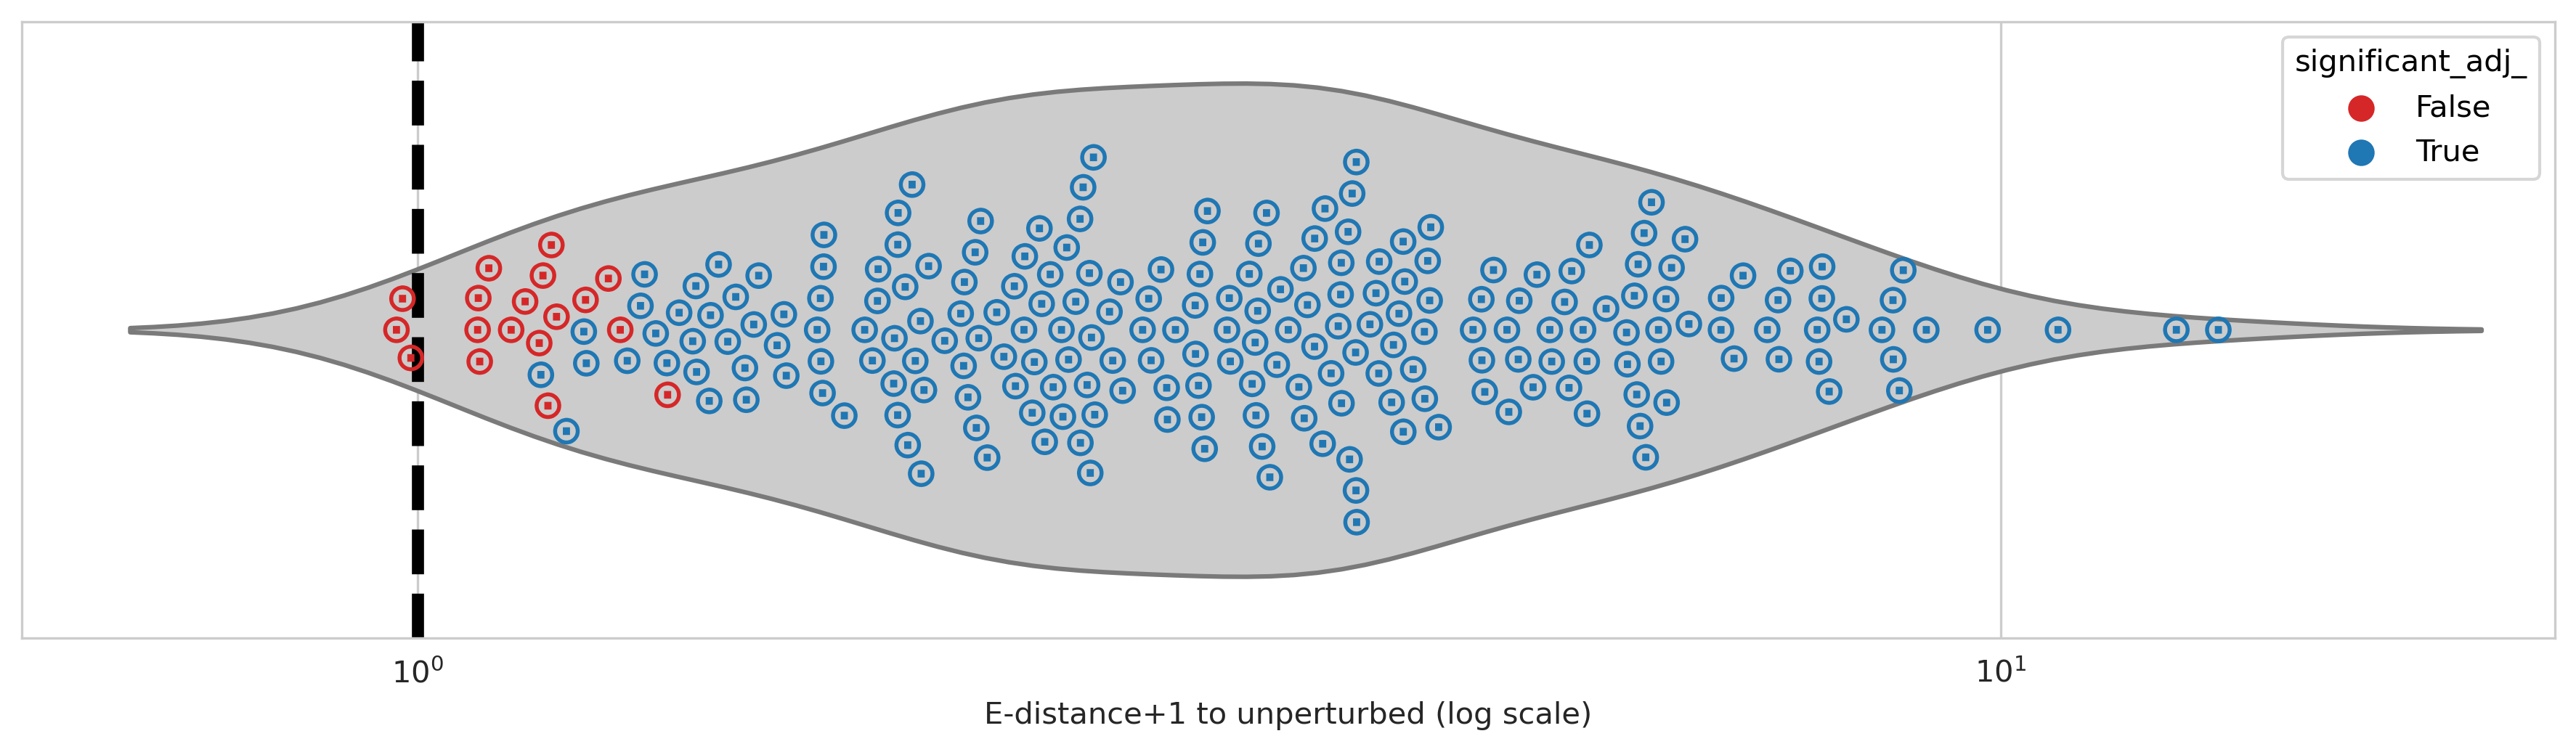

In [97]:
scale=0.75
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[20*scale, 5*scale], dpi=300)  # [8*scale, 5*scale]
estats_control['tmp'] = np.log10(estats_control['E-statistic']+1)
sns.violinplot(data=estats_control.drop('control'), x='tmp', inner=None, color=".8", width=0.8)
ax = sns.swarmplot(data=estats_control.drop('control'), x=estats_control.drop('control')['tmp'], y=['']*len(estats_control.drop('control')), size=10, marker='$\mathbf{\odot}$',
                   edgecolors='white', linewidth=0, hue='significant_adj_', palette=['tab:red', 'tab:blue'])
pl.xlabel('E-distance+1 to unperturbed (log scale)')
ax.axvline(0, c='black', linestyle='--', linewidth=4)

# log scale x ticks
from matplotlib import ticker as mticker
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
xmin, xmax = ax.get_xlim()
tick_range = np.arange(0, xmax)
ax.xaxis.set_ticks(tick_range)
ax.xaxis.set_ticks([np.log10(x+1) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
ax.set_xlim([-0.25, 1.35])
pl.savefig(f'{figure_path}/Fig4C.pdf', bbox_inches='tight')
pl.show()

# Fig4D

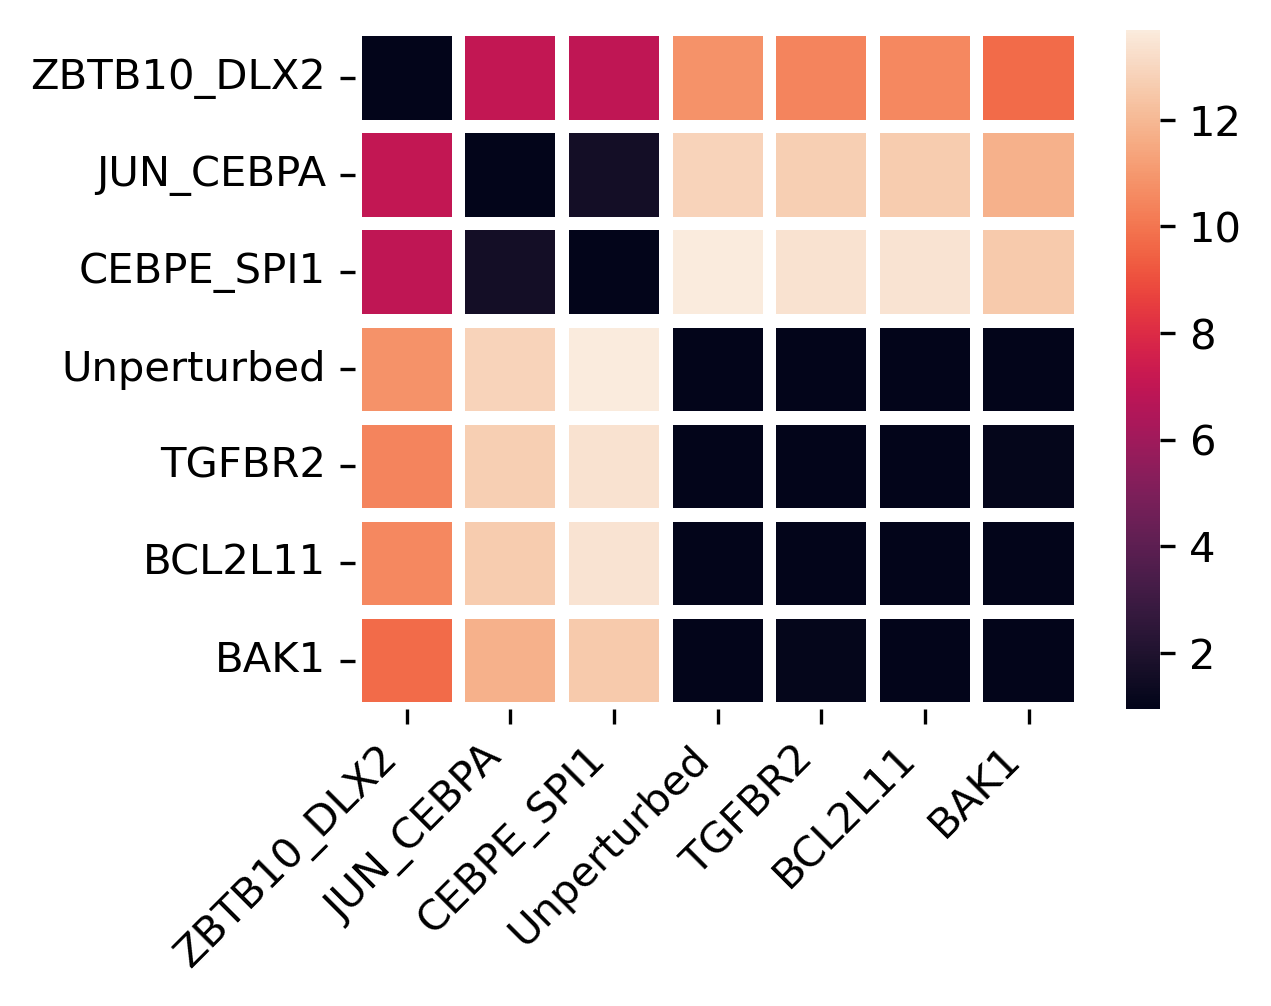

In [39]:
scale=0.3
pl.subplots(figsize=[13*scale,10*scale], dpi=300)
conds = top + ['control'] + bot
sub = estats.loc[conds, conds] + 1
sub = sub.rename({'control': 'Unperturbed'}, axis=1).rename({'control': 'Unperturbed'}, axis=0)
sns.heatmap(sub, robust=False, linewidth=3)
pl.xticks(rotation=45, ha='right')
pl.savefig(f'{figure_path}/Fig4D.pdf', bbox_inches='tight')
pl.show()

# Fig4E

In [98]:
adata = sc.read(f'{SDIR}tmp_data_{key}.h5')

In [99]:
sdata = adata[np.isin(adata.obs.perturbation, top+['control'])].copy()  # bot
sc.pp.pca(sdata, use_highly_variable=False)
sc.pp.neighbors(sdata)
sc.tl.umap(sdata)

# ['bot', 'control', 'top']
sdata.uns['group_colors'] = ['tab:grey', 'tab:red']  # ['tab:blue', 'tab:grey', 'tab:red']
from matplotlib.cm import get_cmap
colors_top = {g: get_cmap('Reds')((i+1)/N) for i, g in enumerate(top)}
colors_bot = {g: get_cmap('Blues')((i+1)/N) for i, g in enumerate(bot)}
colors_control = {'control': 'tab:grey'}
colors = {**colors_top, **colors_bot, **colors_control}
sdata.uns['perturbation_colors'] = [colors[g] for g in np.sort(pd.unique(sdata.obs.perturbation))]

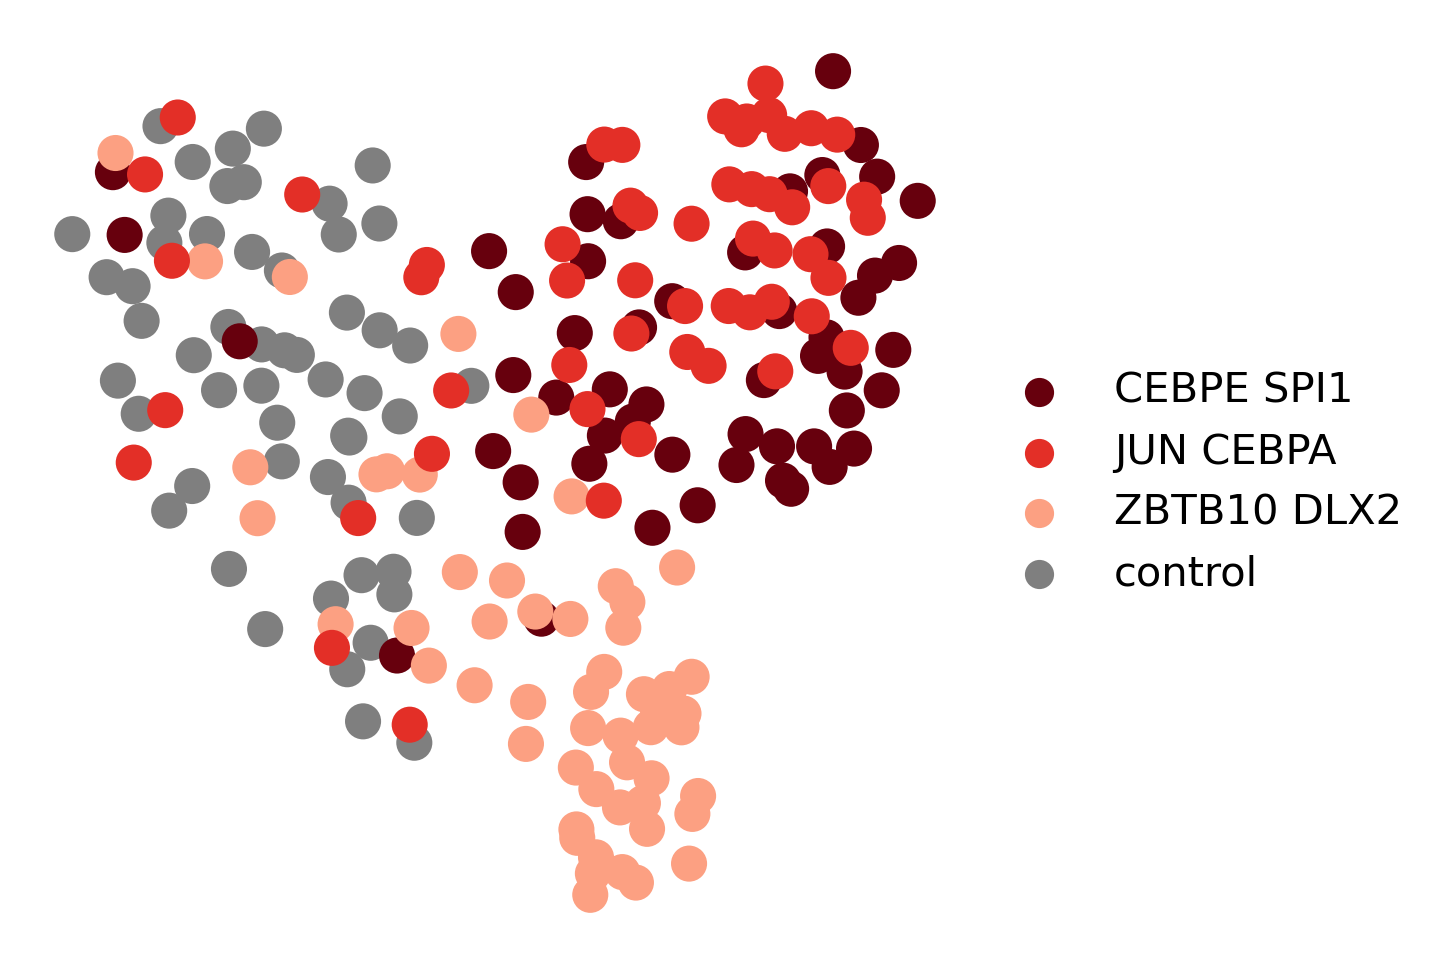

In [106]:
scv.pl.scatter(sdata, color='perturbation', legend_loc='right margin', figsize=[4,4], show=False, dpi=300, title='', s=300)
pl.savefig(f'{figure_path}/Fig4E_top.pdf', bbox_inches='tight')
pl.show()

In [107]:
sdata = adata[np.isin(adata.obs.perturbation, bot+['control'])].copy()  # bot
sc.pp.pca(sdata, use_highly_variable=False)
sc.pp.neighbors(sdata)
sc.tl.umap(sdata)

# ['bot', 'control', 'top']
sdata.uns['group_colors'] = ['tab:blue', 'tab:grey']  # ['tab:blue', 'tab:grey', 'tab:red']
from matplotlib.cm import get_cmap
colors_top = {g: get_cmap('Reds')((i+1)/N) for i, g in enumerate(top)}
colors_bot = {g: get_cmap('Blues')((i+1)/N) for i, g in enumerate(bot)}
colors_control = {'control': 'tab:grey'}
colors = {**colors_top, **colors_bot, **colors_control}
sdata.uns['perturbation_colors'] = [colors[g] for g in np.sort(pd.unique(sdata.obs.perturbation))]

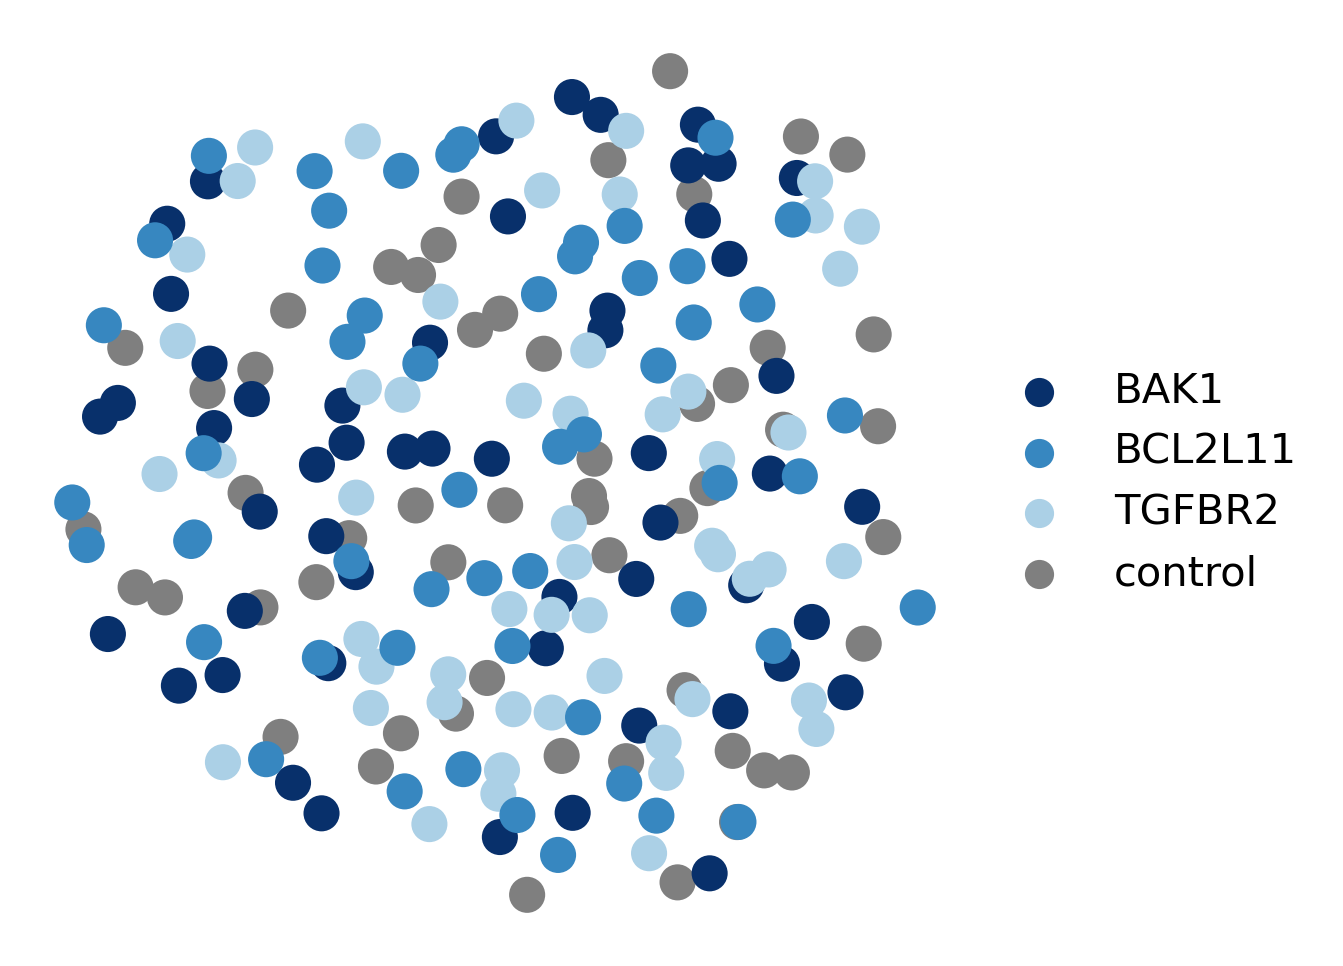

In [108]:
scv.pl.scatter(sdata, color='perturbation', legend_loc='right margin', figsize=[4,4], show=False, dpi=300, title='', s=300)
pl.savefig(f'{figure_path}/Fig4E_bottom.pdf', bbox_inches='tight')
pl.show()

# Supplement

## SuppTab4

In [109]:
res={}
for key in h5_files.keys():
    file = f'{table_path}/etest_{key}_tables.csv'
    if not os.path.exists(file):
        continue
    # load test results
    t = pd.read_csv(file, index_col=0)
    res[key] = t

In [110]:
tab = pd.concat(res).reset_index()
tab.columns=['dataset', 'perturbation', 'edist_to_unperturbed', 'pvalue', 'significant', 'pvalue_adj', 'significant_adj']
tab.to_csv(f'{supp_path}/SuppTab4.csv')

In [111]:
tab.head()

,dataset,perturbation,edist_to_unperturbed,pvalue,significant,pvalue_adj,significant_adj
0,PapalexiSatija2021_eccite_arrayed_RNA,ATF2,19.341576,0.00,True,0.00,True
1,PapalexiSatija2021_eccite_arrayed_RNA,CAV1,37.631357,0.00,True,0.00,True
2,PapalexiSatija2021_eccite_arrayed_RNA,ETV7,4.753141,0.06,False,0.06,False
3,PapalexiSatija2021_eccite_arrayed_RNA,IFNGR1,112.180316,0.00,True,0.00,True
4,PapalexiSatija2021_eccite_arrayed_RNA,IRF1,12.063627,0.00,True,0.00,True


## SuppFig4C

In [19]:
key = 'NormanWeissman2019_filtered'
tab = pd.read_csv(f'{table_path}/etest_{key}_tables.csv', index_col=0)

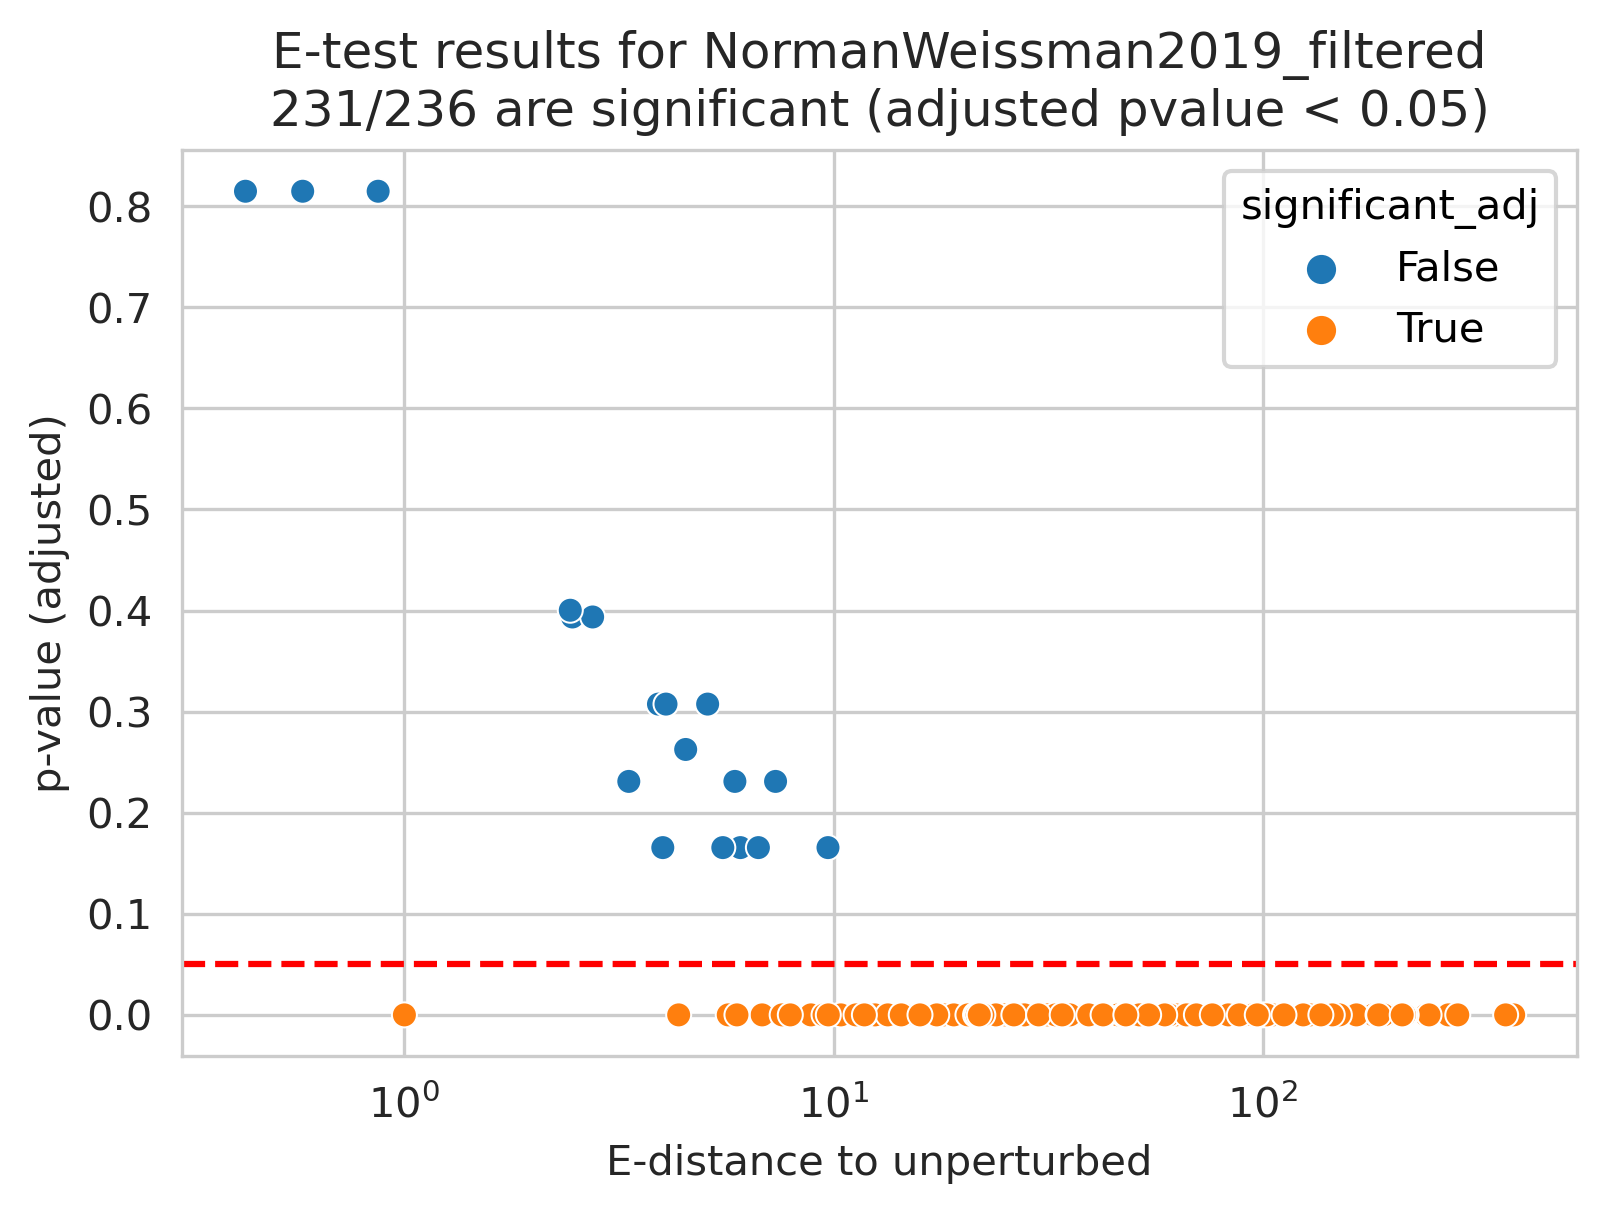

In [20]:
pseudocount = 1
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(dpi=300)
sns.scatterplot(data=tab, x=tab.edist+pseudocount, y=tab.pvalue_adj, hue='significant_adj')
pl.xlabel(f'E-distance to unperturbed')
sig = np.sum(tab['significant'])
total = len(tab)-1
pl.title(f'E-test results for {key}\n{sig}/{total} are significant (adjusted pvalue < 0.05)')
pl.xscale('log')
pl.ylabel('p-value (adjusted)')
pl.axhline(0.05, c='r', linestyle='--')
pl.savefig(f'{supp_path}/SuppFig4B.pdf', bbox_inches='tight')
pl.show()

## SuppFig4D

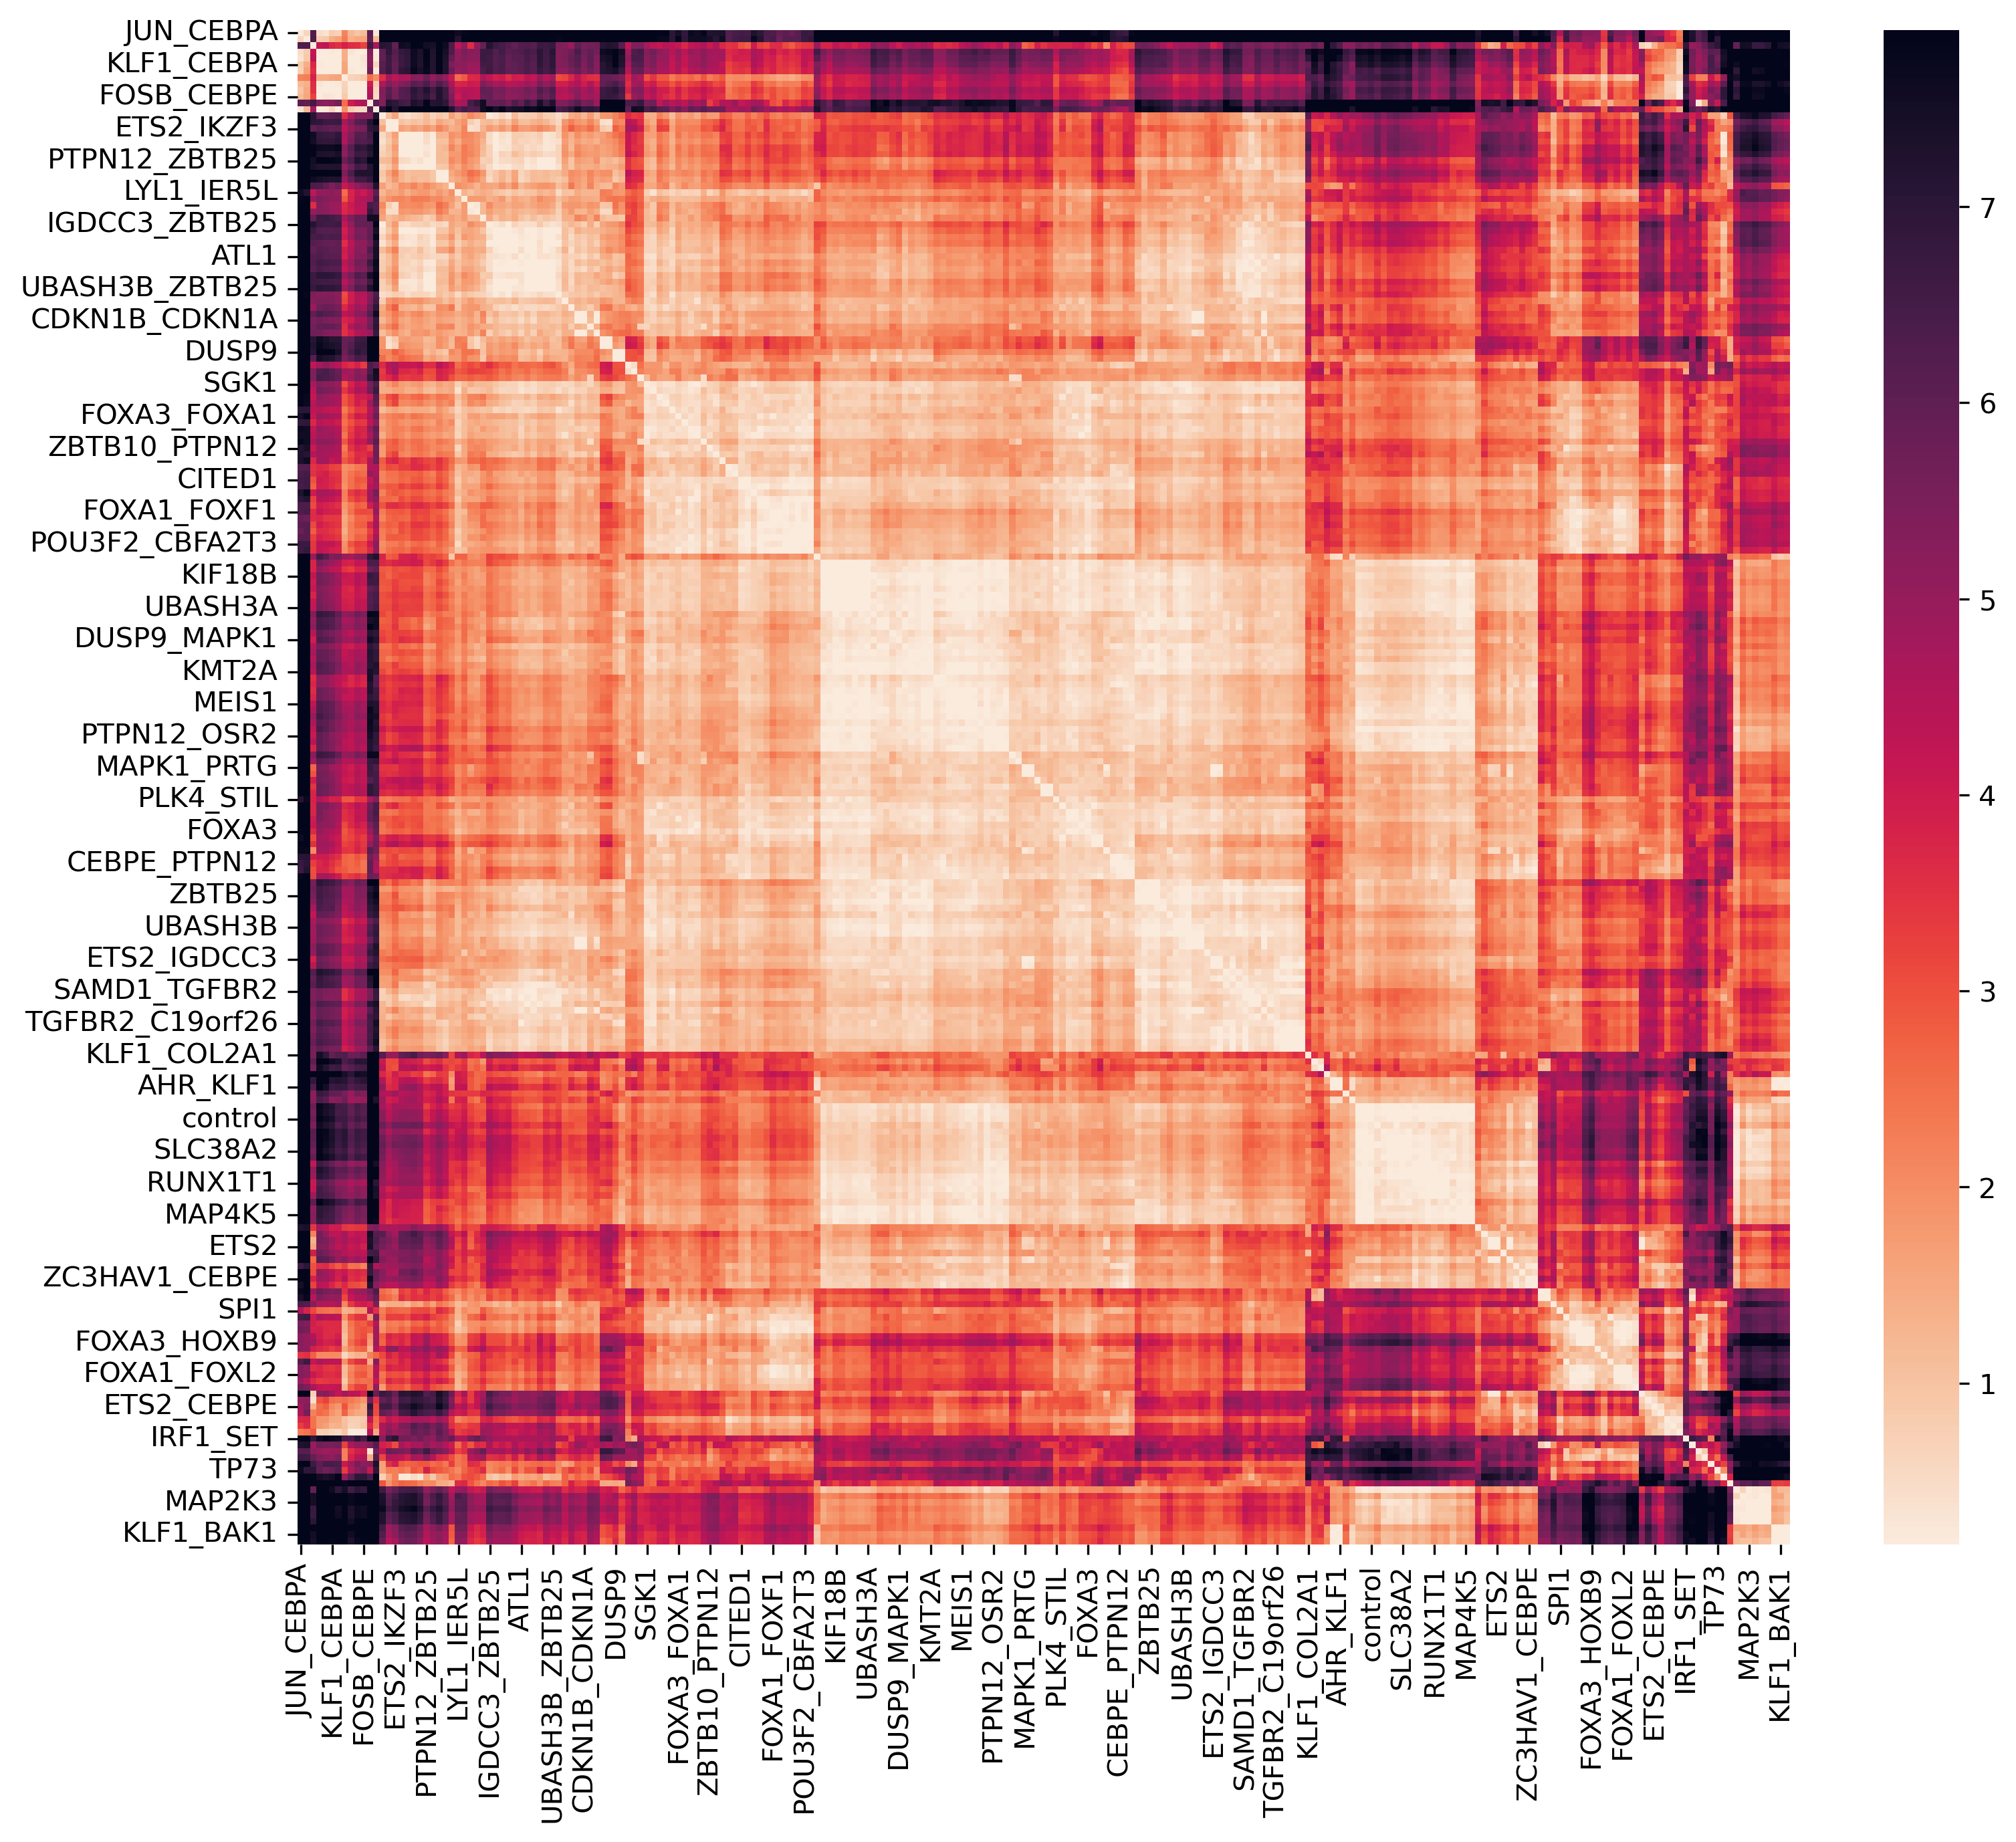

In [21]:
pl.figure(figsize=[12,10], dpi=300)
sns.heatmap(estats, robust=True, cmap='rocket_r')
pl.savefig(f'{supp_path}/SuppFig4D.pdf', bbox_inches='tight')
pl.show()

# SuppFig4X

In [137]:
if os.path.exists(f'{supp_path}/SuppTab4.csv'):
    tab = pd.read_csv(f'{supp_path}/SuppTab4.csv', index_col=0)
else:
    res={}
    for key in h5_files.keys():
        file = f'{table_path}/etest_{key}_tables.csv'
        if not os.path.exists(file):
            continue
        # load test results
        t = pd.read_csv(file, index_col=0)
        res[key] = t
    tab = pd.concat(res).reset_index()
    tab.columns=['dataset', 'perturbation', 'edist_to_unperturbed', 'pvalue', 'significant', 'pvalue_adj', 'significant_adj']
tab = tab[~pd.isna(tab.significant_adj)]
tab.significant_adj = np.array(tab.significant_adj, dtype=bool)

In [139]:
nperts = pd.DataFrame(tab.value_counts('dataset'), columns=['nperts'])
significant_adj = pd.DataFrame(tab.groupby('dataset').sum()['significant_adj'], columns=['significant_adj'])
mean_edist = pd.DataFrame(tab.groupby('dataset').mean()['edist_to_unperturbed']+1)

In [141]:
df = pd.concat([nperts, mean_edist, significant_adj], axis=1)
df['perc_sig'] = np.round(100* df['significant_adj'] / df['nperts'], 2)

# fix typo
df = df.rename({'McFarlandTshemiak2020_all_expts_combined': 'McFarlandTsherniak2020'})

# make labels pretty and more compact
df['dataset_pretty'] = [x.replace('TAP_SCREEN__', '') for x in df.index]
df['dataset_pretty'] = [x.replace('_', '\n(', 1)+')' if '_' in x else x for x in df.dataset_pretty]
df['dataset_pretty'] = [x.replace('_', ' ') for x in df.dataset_pretty]

df

,nperts,edist_to_unperturbed,significant_adj,perc_sig,dataset_pretty
dataset,,,,,
SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen,306,8.691779,214,69.93,SchraivogelSteinmetz2020\n(chromosome 11 screen)
FrangiehIzar2021_RNA,240,1.032469,6,2.50,FrangiehIzar2021\n(RNA)
NormanWeissman2019_filtered,237,65.046783,219,92.41,NormanWeissman2019\n(filtered)
SrivatsanTrapnell2020_sciplex3,189,4.492356,157,83.07,SrivatsanTrapnell2020\n(sciplex3)
TianKampmann2021_CRISPRi,184,2.305975,9,4.89,TianKampmann2021\n(CRISPRi)
TianKampmann2021_CRISPRa,98,7.456085,16,16.33,TianKampmann2021\n(CRISPRa)
PapalexiSatija2021_eccite_RNA,84,27.345626,28,33.33,PapalexiSatija2021\n(eccite RNA)
DixitRegev2016,60,4.212155,1,1.67,DixitRegev2016
ShifrutMarson2018,48,2.876938,1,2.08,ShifrutMarson2018


In [143]:
# add info on perturbation type
metadata = pd.read_excel('../metadata/scperturb_dataset_info_180822.xlsx', index_col=0)
for index in df.index:
    df.loc[index, 'perturbation_type'] = pd.unique(metadata.loc[index.split('_')[0]].Perturbation)[0]
df.perturbation_type[df.perturbation_type=='CRISPR-cas9, TCR stim'] = 'CRISPR-cas9'

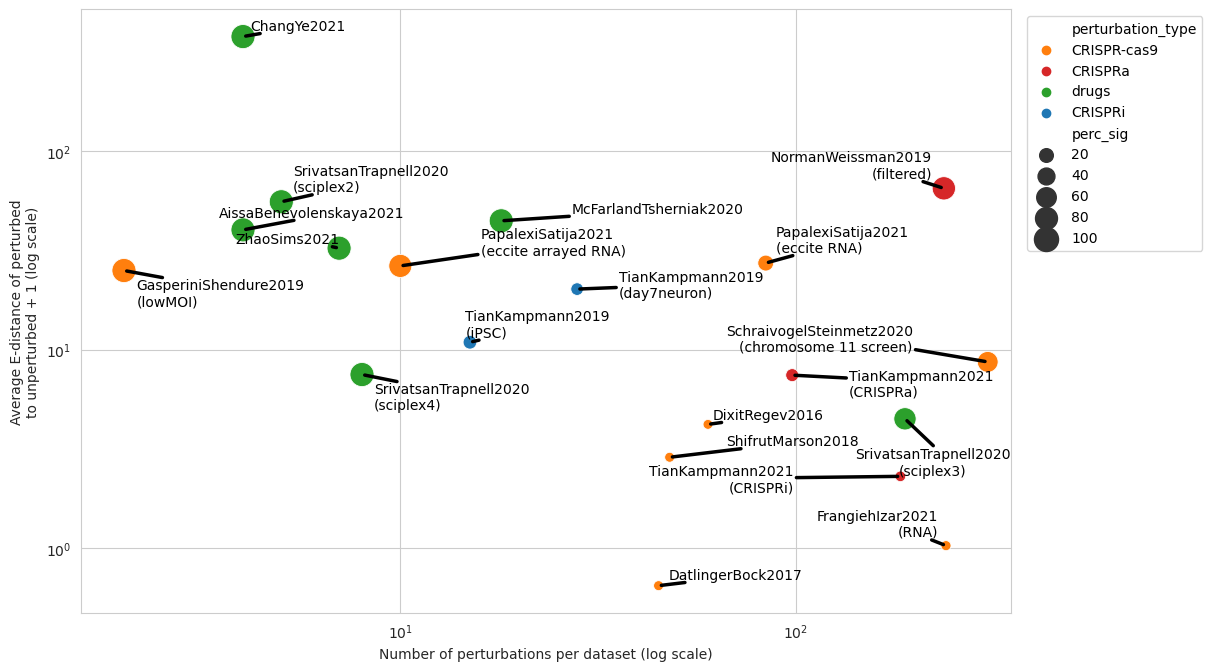

In [149]:
from adjustText import adjust_text

x = 'nperts'
y = 'edist_to_unperturbed'

scale = 2
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(dpi=100, figsize=[6*scale,4*scale])
scat=sns.scatterplot(data=df, x=x, y=y, ax=ax, size='perc_sig', sizes=(50, 300), hue='perturbation_type', palette=colors_perturbation_types)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Number of perturbations per dataset (log scale)')
ax.set_ylabel('Average E-distance of perturbed\nto unperturbed + 1 (log scale)')

ax.set_xlim([-45, 350])  # make more space for annotations

# annotate
texts = []
for xx, yy, s in zip(df[x], df[y], df.dataset_pretty):
    texts.append(pl.text(xx, yy, s))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=2.5),
            expand_text=(1.15, 1.5),
            expand_points=(1.15, 1.5),
            expand_objects=(1.15, 1.5)
           )
scat.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
pl.savefig(f'{supp_path}/SuppFig4X.pdf', bbox_inches='tight')
pl.show()

# Spacers